 **Lvin Nector D**

 **Roll No: 1936120002**
 ## Importing modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans as sklKMeans
import warnings
# warnings.filterwarnings("ignore")


 ## Loading dataset

In [2]:
names = ['s_len', 's_wid', 'p_len', 'p_wid', 'species']
iris_data = pd.read_csv('./datasets/iris.csv', header=None, names=names)
display(iris_data.head())
print(
    
    f"The data set contains {iris_data.shape[0]} records "
    f"and {iris_data.shape[1]} features.",
    iris_data['species'].value_counts(), sep="\n"
)
train_x = iris_data.drop("species", axis=1)
train_y = iris_data["species"]


,s_len,s_wid,p_len,p_wid,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The data set contains 150 records and 5 features.
virginica     50
setosa        50
versicolor    50
Name: species, dtype: int64


 ## Evaluation metrics

In [3]:
def distortion(data, centroids):
    return sum(
        np.min(cdist(data, centroids, 'euclidean'), axis=1)
    ) / data.shape[0]

def silhouette_coefficient(data, clusters):
    return silhouette_score(
        data, labels=clusters, sample_size=clusters.shape[0])


 ## Class for Our implementation of kmeans

In [4]:
class KMeans:
    """The k-means algorithm."""

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.data = pd.DataFrame()
        self.centroids = pd.DataFrame()
        self.clusters = np.ndarray(1)

    def compute_clusters(self, points):
        return np.argmin(
            np.linalg.norm(
                points[:, np.newaxis]-self.centroids,
                axis=2),
            axis=1)

    def train(self, data):
        self.data = data.copy(deep=True)
        self.centroids = self.data.drop_duplicates().sample(
            n=self.n_clusters, random_state=1).values
        old_centroids = np.ndarray(1)
        while np.all(old_centroids != self.centroids):
            old_centroids = self.centroids.copy()
            self.clusters = self.compute_clusters(self.data.values)
            for cluster_id in range(self.n_clusters):
                cluster = self.data.iloc[self.clusters == cluster_id]
                if len(cluster):
                    self.centroids[cluster_id] = cluster.mean()
        return self

    @property
    def silhouette_coefficient(self):
        return silhouette_coefficient(self.data, self.clusters)

    @property
    def distrotion(self):
        return distortion(self.data, self.centroids)



 ## Test Run

/home/livin/anaconda3/envs/test/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


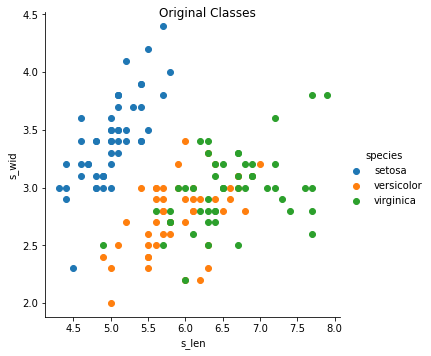

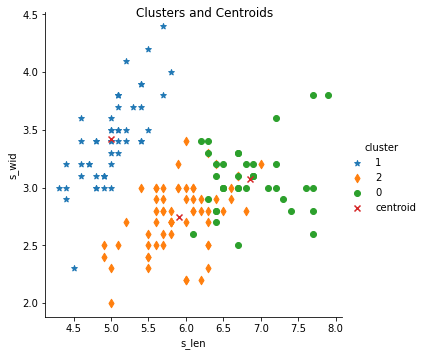

In [5]:
k = 3
kmeans = KMeans(n_clusters=k)
kmeans.train(train_x)
iris_data['cluster'] = kmeans.clusters
centroids = pd.DataFrame(kmeans.centroids, columns=train_x.columns)
centroids["cluster"] = "centroid"
all_data = pd.concat([iris_data, centroids])
sns.FacetGrid(all_data, hue="species", size=5)\
    .map(plt.scatter, "s_len", "s_wid")\
    .add_legend()\
    .fig.suptitle("Original Classes")
plt.show()
sns.FacetGrid(all_data, hue="cluster", size=5, hue_kws={"marker": ["*", "d", "o", "x"]})\
    .map(plt.scatter, "s_len", "s_wid")\
    .add_legend()\
    .fig.suptitle("Clusters and Centroids")
plt.show()

 ## Test out multiple values for k

In [6]:
sil_coefs = []
distortions = []
K = [2, 3, 4, 5]
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.train(train_x)
    s_c = kmeans.silhouette_coefficient
    dist = kmeans.distrotion
    print(f"For k={k}\tAvg. Sil. Coef: {s_c}\tDistortion: {dist}")
    distortions.append(dist)
    sil_coefs.append(s_c)

For k=2	Avg. Sil. Coef: 0.6808136202713507	Distortion: 0.8560279682448627
For k=3	Avg. Sil. Coef: 0.5525919445213673	Distortion: 0.6488394948953339
For k=4	Avg. Sil. Coef: 0.4939832000766898	Distortion: 0.5761071605046977
For k=5	Avg. Sil. Coef: 0.44071269551477504	Distortion: 0.5429157652459413


 ## Elbow plot

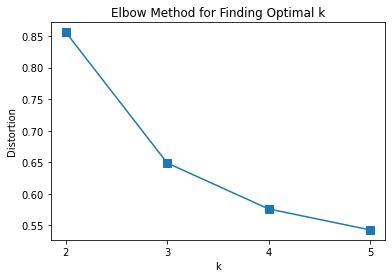

In [7]:
plt.plot(K, distortions, 's-', markersize=8)
plt.xlabel('k')
plt.xticks(K)
plt.ylabel('Distortion')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

 ## Implementation with scikit learn

In [8]:

k = 2
kmeans = sklKMeans(n_clusters=k, init='random').fit(train_x.values)
s_c = silhouette_coefficient(train_x, kmeans.labels_)
dist = distortion(train_x, kmeans.cluster_centers_)
print(f"For k={k}\tAvg. Sil. Coef: {s_c}\tDistortion: {dist}")


For k=2	Avg. Sil. Coef: 0.6808136202713507	Distortion: 0.856027968244863


 # GMM

In [9]:

import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


class GMM:
    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X, means=None, plot_params={}):
        n_row, n_col = X.shape
        self.X = X
        self.resp = np.zeros((n_row, self.n_components))
        if means is not None:
            self.means = means
        else:
            np.random.seed(self.seed)
            chosen = np.random.choice(n_row, self.n_components, replace=False)
            self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)

        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar=False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []
        self.draw("Initial Clusters", **plot_params)
        plt.show()
        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)
            if i == 0:
                self.draw("Clusters after 1 iteration", **plot_params)
                plt.show()
            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        self.draw("Final Clusters", **plot_params)
        plt.show()
        plt.plot(self.log_likelihood_trace, "-s")
        plt.title("Log Likelihood")
        plt.show()
        return self

    def _do_estep(self, X):
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis=1)))
        self.resp = self.resp / self.resp.sum(axis=1, keepdims=1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(
                self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        resp_weights = self.resp.sum(axis=0)
        self.weights = resp_weights / X.shape[0]
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]

        return self

    def draw(
        self, title="Plot", xlim=(-10, 10), ylim=(-10, 10),
        scatter=True, scatter_params={}
    ):
        plt.figure()
        if scatter:
            plt.scatter(
                self.X[:, 0], self.X[:, 1], **scatter_params)
        delta = 0.05
        k = self.means.shape[0]
        x = np.arange(*xlim, delta)
        y = np.arange(*ylim, delta)
        x_grid, y_grid = np.meshgrid(x, y)
        coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
        col = ['green', 'red', 'indigo']
        for i in range(k):
            mean = self.means[i]
            cov = self.covs[i]
            plt.scatter(mean[0], mean[1], color=col[i])
            z_grid = multivariate_normal(mean, cov).pdf(
                coordinates).reshape(x_grid.shape)
            plt.contour(x_grid, y_grid, z_grid, levels=[.01], colors=col[i])

        plt.title(title)
        plt.tight_layout()

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10],seed = 1):
    np.random.seed(seed)
    x = np.ndarray((k,points_per_cluster,dim))
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = cov @ cov.T
        x[i] = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
    x = x.reshape(k*points_per_cluster,dim)

    if(dim == 2):
        plt.figure()
        plt.scatter(x[..., 0], x[..., 1], s=3, alpha=0.4)
        plt.show()
    return x

 # GMM on random data using random means

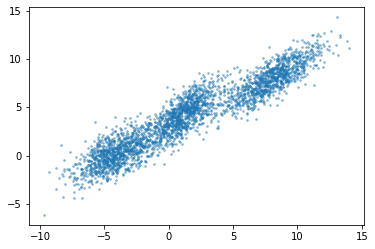

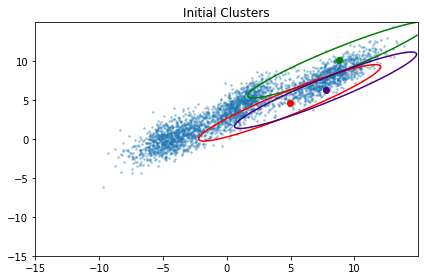

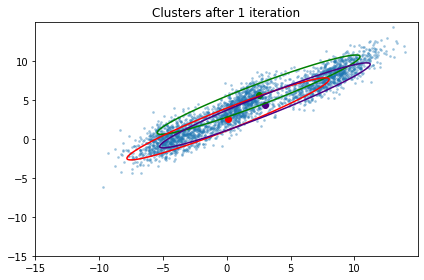

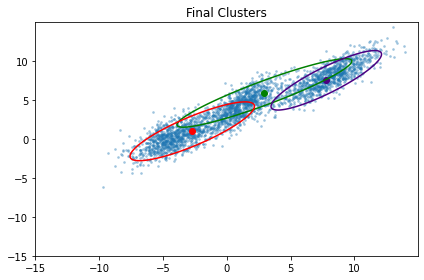

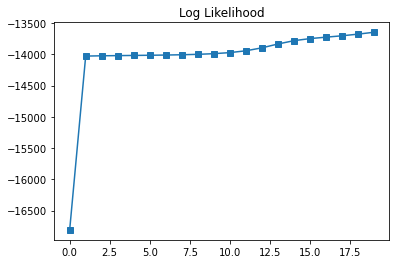

In [10]:
X = gen_data(k=3, dim=2, points_per_cluster=1000, seed=3)
gmm = GMM(3, 20, 10e-4, 5)
gmm.fit(X, plot_params={
    "xlim": (-15, 15), "ylim": (-15, 15),
    "scatter_params":{"s":3,"alpha":.3}
})


 # GMM On Iris dataset using kmeans to initialize means

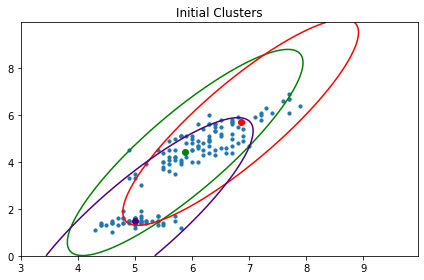

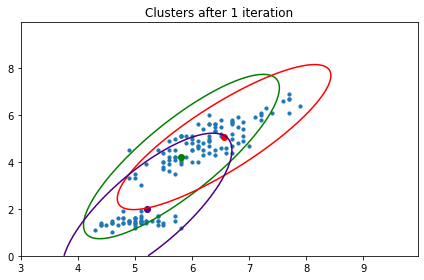

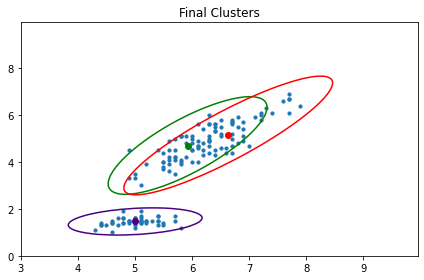

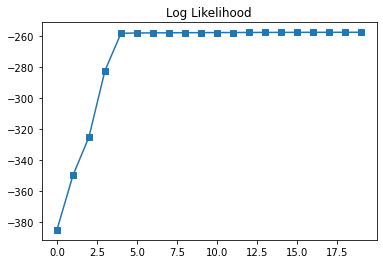

In [11]:
X = train_x.values[...,(0,2)]
kmeans = KMeans(3)
kmeans.train(train_x[["s_len","p_len"]])
gmm = GMM(3,20,10e-4,5)
gmm.fit(X,kmeans.centroids,plot_params={
    "xlim":(3,10),"ylim":(0,10),
    "scatter_params":{"s":10,"alpha":1}
})

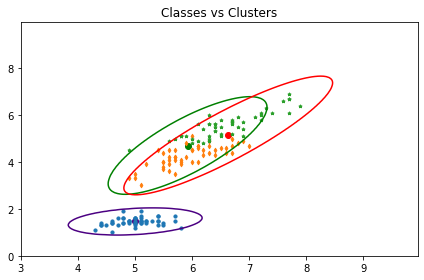

In [12]:
gmm.draw("Classes vs Clusters",xlim=(3,10),ylim=(0,10),scatter=False)

classes = train_y.unique()
Y = train_y.values
shapes = ['o',"d","*"]
for class_,shape in zip(classes,shapes):
    idx = np.argwhere(Y==class_)
    plt.scatter(X[...,0][idx],X[...,1][idx],s=10,alpha=1,marker=shape)
